O que é <b>BERT</b>?

<b>BERT</b> significa <b>B</b>idirectional <b>E</b>ncoder <b>R</b>epresentations from <b>T</b>ransformers.

<b>Bidirecional</b> - para entender o texto que estamos procurando, temos de olhar para trás (nas palavras anteriores) e para a frente (nas próximas palavras)

<b>Transformers</b> - O mecanismo de Atenção é tudo que precisamos. O Transformer lê sequências inteiras de tokens de uma vez. Em certo sentido, o modelo é não direcional, enquanto os LSTMs leem sequencialmente (da esquerda para a direita ou da direita para a esquerda). O mecanismo de atenção permite o aprendizado de relações contextuais entre palavras.

<b>Embeddings</b> de palavras contextualizadas (pré-treinadas) - O artigo ELMO apresentou uma maneira de codificar palavras com base em seu significado / contexto.

O BERT foi treinado mascarando 15% dos tokens com o objetivo de adivinhá-los. Um objetivo adicional era prever a próxima frase.

BERT é simplesmente uma stack pré-treinada de Transformer Encoders com duas versões 
- com 12 (BERT base) 
- com 24 (BERT Large).

A BERT pode ser utilizada em inúmeras tasks do NLP, aqui <b>tentaremos</b> utilizar para classificar se, dadas duas entidades e a sentença a qual elas pertencem, há uma relação semântica entre elas.

In [1]:
#Trecho para ser executado quando no Sagemaker
#!pip install transformers==3.3.1
#!pip install torch==1.6.0

Importando as bibliotecas necessárias para rodar o modelo

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim, functional as F
from torch.utils.data import Dataset, DataLoader

import os

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

Setando alguns parametros básicos

In [3]:
#Configurando parametros para visualização de dados
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
class_names = ['negativa', 'positiva']

#Configuração de SEED 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Flag para utilizar cuda quando presente uma GPU ou utilizar CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


Capturando os dados

In [4]:
pwd = %pwd
pwd = os.path.join(os.path.dirname(pwd), 'data')
print(pwd)

D:\Mestrado\2020-02\Deep Learning\relation-extraction-deep-learning\data


In [5]:
#Trecho para ser executado via Sagemaker
# pwd = os.path.join(os.getcwd(), 'data').replace("notebook","")

# pwd = os.path.join(os.getcwd(), 'data').replace("notebook\\","")
# print(pwd)

#data = pd.read_csv(os.path.join(pwd, 'input/data_full_tmp.csv'), sep=';').replace({np.NaN: None})
data = pd.read_csv(os.path.join(pwd, 'input/data_full.csv'), sep=';').replace({np.NaN: None})
data.columns = ['sentenca','entidade1','entidade1_tipo','relacao','entidade2','entidade2_tipo']

data['class'] = data['relacao'].apply(lambda x: 0 if x is None else 1)
data.head()

,sentenca,entidade1,entidade1_tipo,relacao,entidade2,entidade2_tipo,class
0,A Kroton anunciou uma parceria com o Cubo Itaú...,Kroton,ORG,anunciou uma parceria com,Cubo Itaú,ORG,1
1,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,reuniu em,Cuiabá,PLC,1
2,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,None,Mato Grosso,PLC,0
3,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,None,Brasil,PLC,0
4,"O usuário consegue comparar prazos , condições...",Bradesco,ORG,None,Banco do Brasil,ORG,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 7 columns):
sentenca          2143 non-null object
entidade1         2143 non-null object
entidade1_tipo    2143 non-null object
relacao           1100 non-null object
entidade2         2143 non-null object
entidade2_tipo    2142 non-null object
class             2143 non-null int64
dtypes: int64(1), object(6)
memory usage: 117.3+ KB


Verificando como o dataset está populado.
Não informações nulas nos campos de Sentença, Entidade 1, Entidade 2 e Class

In [7]:
NUM_AMOSTRA = 30

# Gambi pra deixar o dataset inicial balanceado
# - Se for um teste aleatório somente com uma amostragem de dados, vai pegar essa quantidade e dividir 
# ao meio para pegar 50% de cada classe
# - Se for um teste com todo o dataset, pega a quantidade de registros da classe minoritária

if NUM_AMOSTRA is not None:
    data_positivo = data[data['class']==1]
    print(data_positivo.shape)

    data_negativo = data[data['class']==0]
    print(data_negativo.shape)
    
    data = data_positivo.head(int(NUM_AMOSTRA/2)).append(data_negativo.head(int(NUM_AMOSTRA/2)))
else:
    data_positivo = data[data['class']==1]
    print(data_positivo.shape)

    data_negativo = data[data['class']==0]
    print(data_negativo.shape)
    
    MIN_AMOSTRA = min(data_negativo.shape[0], data_positivo.shape[0])
    print(MIN_AMOSTRA)
    data = data_positivo.head(int(MIN_AMOSTRA)).append(data_negativo.head(int(MIN_AMOSTRA)))

data.info()

(1100, 7)
(1043, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 21
Data columns (total 7 columns):
sentenca          30 non-null object
entidade1         30 non-null object
entidade1_tipo    30 non-null object
relacao           15 non-null object
entidade2         30 non-null object
entidade2_tipo    30 non-null object
class             30 non-null int64
dtypes: int64(1), object(6)
memory usage: 1.9+ KB


Verificando o balanceamento de classes

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


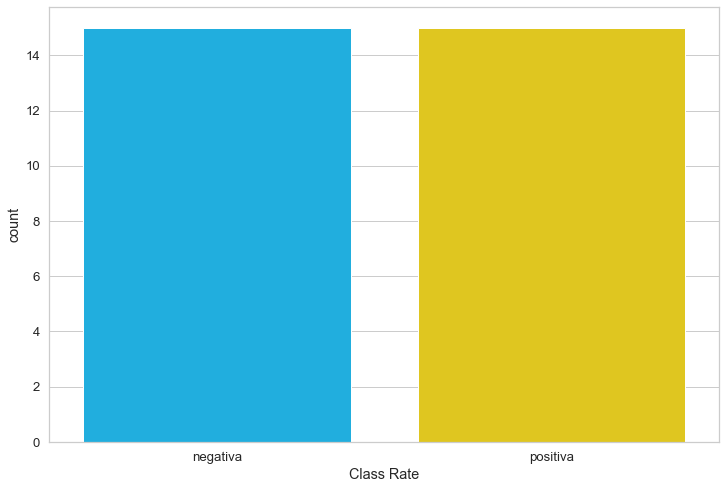

In [8]:
ax = sns.countplot(data['class'])
plt.xlabel('Class Rate')
ax.set_xticklabels(class_names);

<h2>Pre-Processamento</h2>

É preciso converter texto em números. 
O BERT exige ainda mais atenção. Dessa maneira:

- Adicionaremos tokens especiais para separar frases e fazer a classificação
- Passaremos sequências de comprimento constante (introduzir preenchimento)
- Criaremos uma matriz de 0s (token de teclado) e 1s (token real) chamada máscara de atenção
- A biblioteca Transformers fornece vários modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Também inclui tokenizers pré-construídos que fazem o trabalho pesado para nós!

Carregando o tokenizador pre-treinado da BERT

In [9]:
# PRE_TRAINED_MODEL_NAME = '/root/.cache/torch/transformers/neuralmind-bert-large-portuguese-cased/'
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Entendendo o que faz o tokenizador, pegando apenas uma sentença do corpus inteiro.

In [10]:
sentenca_amostra = data['sentenca'].iloc[0]
tokens = tokenizer.tokenize(sentenca_amostra)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'- Sentença: {sentenca_amostra}')
print(f'- Tokens: {tokens}')
print(f'- Token IDs: {token_ids}')

- Sentença: A Kroton anunciou uma parceria com o Cubo Itaú , que dará origem à vertical “Cubo Education” , um espaço dedicado ao fomento de edtechs – tecnologia aplicada à educação .
- Tokens: ['A', 'K', '##ro', '##ton', 'anunciou', 'uma', 'parceria', 'com', 'o', 'Cub', '##o', 'Ita', '##ú', ',', 'que', 'dar', '##á', 'origem', 'à', 'vertical', '“', 'Cub', '##o', 'Educa', '##tion', '”', ',', 'um', 'espaço', 'dedicado', 'ao', 'fome', '##nto', 'de', 'ed', '##tec', '##h', '##s', '–', 'tecnologia', 'aplicada', 'à', 'educação', '.']
- Token IDs: [177, 461, 157, 897, 3127, 230, 4495, 170, 146, 18842, 22280, 4008, 22332, 117, 179, 2822, 22303, 2008, 353, 14357, 1112, 18842, 22280, 14191, 1131, 22354, 117, 222, 2363, 8055, 320, 11062, 234, 125, 902, 8948, 22296, 22281, 1379, 4277, 11107, 353, 3478, 119]


<h2> Tokens Especiais </h2>

[SEP] - Token que marca o fim da sentença.
('[SEP]', 102)

[CLS] - Token que marca o início da sentença.
('[CLS]', 101)

[PAD] - Token para preenchimento da sentença para que todas fiquem em um cumprimento fixo.
('[PAD]', 0)

[UNK] - Token para todos os tokens que a BERT desconhece
('[UNK]', 100)

<h2>Estabelecendo o comprimento da sentença</h2>

O BERT trabalha com sequências de comprimento fixo. 
Vamos armazenar o comprimento do token de cada avaliação e capturar o comprimento máximo

In [11]:
token_lens = []
for txt in data.sentenca:
    tokens = tokenizer.encode(txt, max_length=512, truncation= True)
    token_lens.append(len(tokens))
    if len(tokens) > 170:
        print(txt)
    
MAX_LENGHT = max(token_lens)
print(MAX_LENGHT)

82


Histograma dos tokens

para visualizar a distribuição das sentenças em relação a distribuição dos tokens.

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


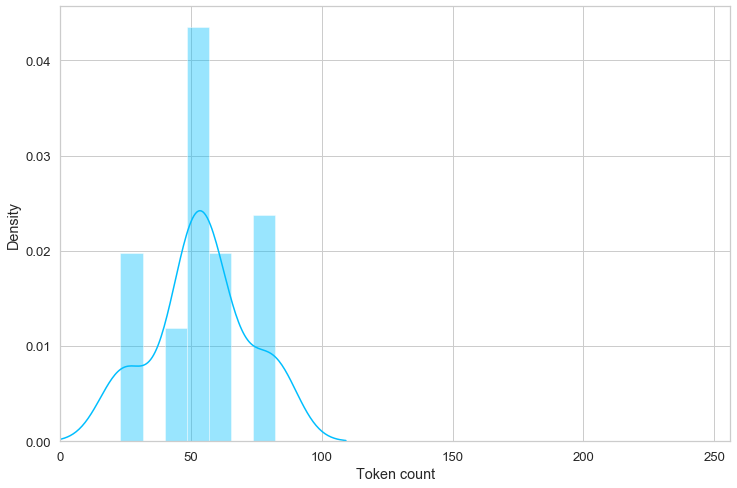

In [12]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

<h2>Classe de pré-processamento</h2>
    
Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Isso será feito a partir de uma classe estabelecida abaixo.

O tokenizer está fazendo a maior parte do trabalho. Também devolve a sentença que foi classificada, para que seja mais fácil avaliar as previsões do modelo. 

In [13]:
class preProccesDataset(Dataset):
    
    def __init__(self, sentence, entity1, entity2, targets, tokenizer, max_len):
        self.sentence = sentence
        self.entity1 = entity1
        self.entity2 = entity2
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, item):
        inputs = [str(self.sentence[item]), str(self.entity1[item]), str(self.entity2[item])]
        target = self.targets[item]
        # Encodamos todas as entradas
        encoding = [
        self.tokenizer.encode_plus(
        x,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True,
        )
        for x in inputs
        ]

        # Contatenamos os ids e attention_masks das sentencas e entidades\n",
        input_ids = torch.cat(tuple(x['input_ids'].flatten() for x in encoding), dim=0)
        attention_mask = torch.cat(tuple(x['attention_mask'].flatten() for x in encoding), dim=0)
        
        return {
          'input_text': inputs,
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'targets': torch.tensor(target, dtype=torch.long)
        }

<h2>Separação dos dados</h2>
Treino, Teste e Validação

Dividindo os dados entre treino (x%) e teste (y%), onde x+y = 100

Em seguida, divide os dados de teste entre teste (x%) e validação (y%), onde x+y = 100

Na função de separação dos dados foi configurado o parâmetro de <b>stratify</b>, para que possamos separar os dados respeitando a distribuição das classes

In [14]:
df_train, df_test = train_test_split(
  data,
  test_size=0.2,
  random_state=RANDOM_SEED,
  stratify = data['class']
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED,
  stratify = df_test['class']
)

df_train.shape, df_test.shape, df_val.shape

((24, 7), (3, 7), (3, 7))

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 10 to 14
Data columns (total 7 columns):
sentenca          24 non-null object
entidade1         24 non-null object
entidade1_tipo    24 non-null object
relacao           12 non-null object
entidade2         24 non-null object
entidade2_tipo    24 non-null object
class             24 non-null int64
dtypes: int64(1), object(6)
memory usage: 1.5+ KB


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 17 to 11
Data columns (total 7 columns):
sentenca          3 non-null object
entidade1         3 non-null object
entidade1_tipo    3 non-null object
relacao           1 non-null object
entidade2         3 non-null object
entidade2_tipo    3 non-null object
class             3 non-null int64
dtypes: int64(1), object(6)
memory usage: 192.0+ bytes


In [17]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 23 to 5
Data columns (total 7 columns):
sentenca          3 non-null object
entidade1         3 non-null object
entidade1_tipo    3 non-null object
relacao           2 non-null object
entidade2         3 non-null object
entidade2_tipo    3 non-null object
class             3 non-null int64
dtypes: int64(1), object(6)
memory usage: 192.0+ bytes


<h2>Data Loader </h2>
Função que auxilia na criação dos dataloaders dos dados utilizando a classe recém criada de processamento de sentenças.

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = preProccesDataset(
        sentence=df['sentenca'].to_numpy(),
        entity1=df['entidade1'].to_numpy(),
        entity2=df['entidade2'].to_numpy(),
        targets=df['class'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
  )

# BATCH_SIZE = 16
# BATCH_SIZE = 1
BATCH_SIZE = 4

Criando os data loaders para cada função de dataset

In [19]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGHT, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGHT, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGHT, BATCH_SIZE)

Exemplo do data loader de treinamento:

In [20]:
df = next(iter(train_data_loader))
print(df.keys())

print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['targets'].shape)

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\transformers\tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([4, 246])
torch.Size([4, 246])
torch.Size([4])


In [21]:
x = next(iter(train_data_loader))
x

{'input_text': [('Agrotools promove painel sobre transformação digital do seguro rural e o crédito no agronegócio; evento é restrito a convidados O que o setor de fintech tem a ver com o AgTech ?',
   'O Lounge Plant contou com patrocínio de SAP , Clube Agro e Azul Linhas Aéreas .',
   'O AgFinTech – A Nova Era do Seguro e Crédito Rural vai reunir , na Casa do Saber , em São Paulo , especialistas de instituições financeiras , além de representante do Banco Central , para falar sobre temas como a Resolução 4.42 7 do BACEN , que permite a utilização do sensoriamento remoto para fins de fiscalização de operações de crédito rural .',
   'O evento Summit AgriHub reuniu nesta quinta-feira (19/04) , em Cuiabá , produtores rurais vindos de vários municípios de Mato Grosso , pesquisadores e empresas de tecnologias do Brasil para debater as novidades incorporadas aos sistemas de produção .'),
  ('Agrotools', 'Lounge Plant', 'Banco Central', 'Summit AgriHub'),
  ('AgTech', 'Clube Agro e Azul Linh

Carregando o modelo pré-treinado BERT

In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

<h2>Modelo Classificador</h2>

Criando um classificador que use o modelo <b>BERT</b>:

O classificador delega a maior parte do trabalho pesado para o BertModel. Usamos uma camada de eliminação para alguma regularização e uma camada totalmente conectada para nossa saída. 

Retorna a saída bruta da última camada, pois isso é necessário para que a função de perda de entropia cruzada em PyTorch funcione.

In [23]:
class ModeloVerificaRelacao(nn.Module):
    
    def __init__(self, n_classes, bert_embedding_model, dropout_prob=0.1):
        super(ModeloVerificaRelacao, self).__init__()
        self._drop_prob = dropout_prob
        
        self.bert = bert_embedding_model if bert_embedding_model is not None else BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        self.out = nn.Sequential(
            nn.Dropout(self._drop_prob),
            nn.Linear(self.bert.config.hidden_size, n_classes),
            nn.Sigmoid()
        )
        
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
    
        return self.out(pooled_output)

Criando uma instância e movê-la para a GPU <b>(caso tenha)</b>

In [24]:
NUM_CLASSES = len(class_names)
print(f"Suggest using {NUM_CLASSES} classes")

model = ModeloVerificaRelacao(n_classes=1, bert_embedding_model=bert_model, dropout_prob=0.1)
model = model.to(device)

Suggest using 2 classes


Lote de exemplo de nossos dados de treinamento movido para a GPU:

In [25]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 246])
torch.Size([4, 246])


<h2>Treinamento</h2>

Para reproduzir o procedimento de treinamento do artigo de BERT, usamos o otimizador AdamW fornecido por Hugging Face. Ele corrige a deterioração do peso. Também usaremos um agendador linear sem etapas de warmup:

In [26]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#loss_fn = nn.BCELoss().to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)

De onde são esses hiperparâmetros? Os autores do BERT têm algumas recomendações para o ajuste fino:

- Tamanho do lote: 16, 32
- Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5
- Número de épocas: 2, 3, 4
- Vamos ignorar a recomendação do número de épocas, mas ficar com o resto. Observe que aumentar o tamanho do lote reduz significativamente o tempo de treinamento, mas oferece menor precisão.

Função auxiliar para treinar o modelo para uma época:

In [27]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    counter = 0
    data_count = len(data_loader)
    
    for d in data_loader:
        counter += 1
        if counter % 10 == 0:
            print("Performing step {" + str(counter) + "} out of a total of {" + str(data_count) + "} steps...")
            
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
                
#         print('Saída Modelo: ' + str(outputs) + '\nPredição 0/1: ' + str((outputs>=0.5).int()) + str('\nValor Real: ' + str(targets)))
        
        preds = (outputs >= 0.5).int().reshape(1,-1).squeeze()
#         preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])
        
        print('Acertos: ' + str(preds == targets))
        print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))
        
#         loss = loss_fn(outputs.float(), targets.float())
        loss = loss_fn(outputs.float(), targets.float().reshape(outputs.size(0),1)) # Muda o formato dos targets de acordo com o batch size
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

O treinamento do modelo deve parecer familiar, exceto por duas coisas. O scheduler é chamado sempre que um lote é alimentado para o modelo. A explosão de gradientes está sendo evitada recortando os gradientes do modelo usando <i><b>clipgrad_norm</b></i>.

Outra função para avaliar o modelo em um determinado data loader:

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        counter = 0
        data_count = len(data_loader)
    
        for d in data_loader:
            counter += 1
            if counter % 10 == 0:
                print("Performing step {" + str(counter) + "} out of a total of {" + str(data_count) + "} steps...")
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
#             print('Saída Modelo: ' + str(outputs) + '\nPredição 0/1: ' + str((outputs>=0.5).int()) + str('\nValor Real: ' + str(targets)))
        
            preds = (outputs>=0.5).int().reshape(1,-1).squeeze()
#             preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])

            print('Acertos: ' + str(preds == targets))
            print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))

#             loss = loss_fn(outputs.float(), targets.float())
            loss = loss_fn(outputs.float(), targets.float().reshape(outputs.size(0),1)) # Muda o formato dos targets de acordo com o batch size
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Usando essas duas funções, temos o loop de treinamento. 
Também armazenaremos o histórico de treinamento:

In [29]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    #b, t = train_epoch(
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
  
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
  
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Acertos: tensor([ True, False,  True, False])
Acertos sumarizados: tensor(2)
Acertos: tensor([ True,  True, False, False])
Acertos sumarizados: tensor(2)
Acertos: tensor([ True, False,  True,  True])
Acertos sumarizados: tensor(3)
Acertos: tensor([ True, False,  True, False])
Acertos sumarizados: tensor(2)
Acertos: tensor([False, False, False,  True])
Acertos sumarizados: tensor(1)
Acertos: tensor([False, False, False,  True])
Acertos sumarizados: tensor(1)
Train loss 0.7211447755495707 accuracy 0.4583333333333333
Acertos: tensor([False, False,  True])
Acertos sumarizados: tensor(1)
Val   loss 0.6485647559165955 accuracy 0.3333333333333333

Epoch 2/2
----------
Acertos: tensor([ True, False,  True,  True])
Acertos sumarizados: tensor(3)
Acertos: tensor([ True,  True, False, False])
Acertos sumarizados: tensor(2)
Acertos: tensor([ True, False,  True,  True])
Acertos sumarizados: tensor(3)
Acertos: tensor([ True, False,  True, False])
Acertos sumarizados: tensor(2)
A

O estado do melhor modelo é armazenado, indicado pela maior precisão de validação.
É possível observar a precisão do treinamento vs validação:

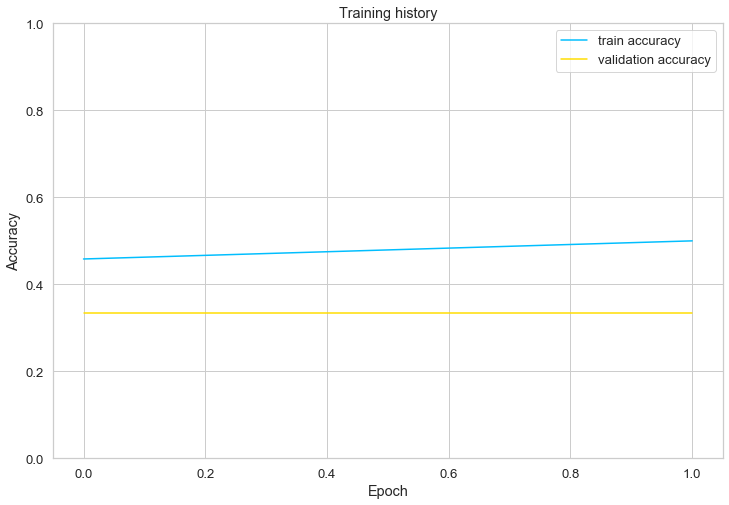

In [30]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

<h2>Avaliação do Modelo</h2>

Avaliação do modelo treinado. Cálculo da acurácia

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


Acertos: tensor([ True,  True, False])
Acertos sumarizados: tensor(2)


0.6666666666666666

Função que vai calcular essa acurácia automaticamente

In [32]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["input_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
        
            preds = (outputs>=0.5).int().reshape(1,-1).squeeze()
#             preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])

            print('Saída Modelo: ' + str(outputs) + '\nPredição 0/1: ' + str(preds) + str('\nValor Real: ' + str(targets)))

            print('Acertos: ' + str(preds == targets))
            print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
  
    return review_texts, predictions, prediction_probs, real_values

<h3>Chamada da Função para calcular as predições</h3>

Semelhante à função de avaliação, exceto que estamos armazenando o texto das sentenças e as probabilidades previstas

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

<h3>Relatório da Classificação</h3>

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

<h3>Matriz de Confusão</h3>

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Classificação Real')
    plt.xlabel('Classificação Predita');
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

show_confusion_matrix(df_cm)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test